In [ ]:
import specsuite as ss
import matplotlib.pyplot as plt
import astropy.units as u
import pandas as pd
import numpy as np

### Defines useful paths
bds = [440, 500]
cal_path  = "../../../APO Data/TOI3884/UT250209/cals"
flux_path = "../../../APO Data/TOI3884/UT250209/flux_cal"
wavecal_path = "../../../Python Scripts/APO_red_wavecal.csv"

### Extracts necessary calibration data
arc     = ss.average_matching_files(cal_path, "neon", crop_bds=bds)
bias    = ss.average_matching_files(cal_path, "bias", crop_bds=bds)
flat    = ss.average_matching_files(cal_path, "flat", crop_bds=bds)
fluxcal = ss.average_matching_files(flux_path, "GD153-wide-center-red", crop_bds=bds) - bias

### Loads pre-existing wavelength calibration
wavecal = pd.read_csv(wavecal_path)
p       = np.poly1d(np.polyfit(wavecal["pixel positions"], wavecal["wavelengths (AA)"], 2))
w_extracted = p(range(len(fluxcal[0])))

### Calibrates the flux calibration exposure
fluxcal = np.array([ss.flatfield_correction(fluxcal, flat)])
guess, _   = ss.find_cal_lines(arc)
warp_model = ss.generate_warp_model(arc, guess)
background = ss.extract_background(fluxcal, warp_model, mask_region=(30, 45))
fluxcal -= background

### Extracts flux from image
flux_extracted, err  = ss.horne_extraction(fluxcal, background, update=False)

## **Basic Usage**
### load_STIS_spectra()

Many standard calibration stars have publicly-available SED's listen on **[STScI's "Calspec" page](https://www.stsci.edu/hst/instrumentation/reference-data-for-calibration-and-tools/astronomical-catalogs/calspec)**. If you would like to quickly load these SEDs into Python, ```load_STIS_spectra()``` allows you to it quickly! You only need to provide the ```name``` of the star (which should exactly match an entry in Table 1 from the linked page)...

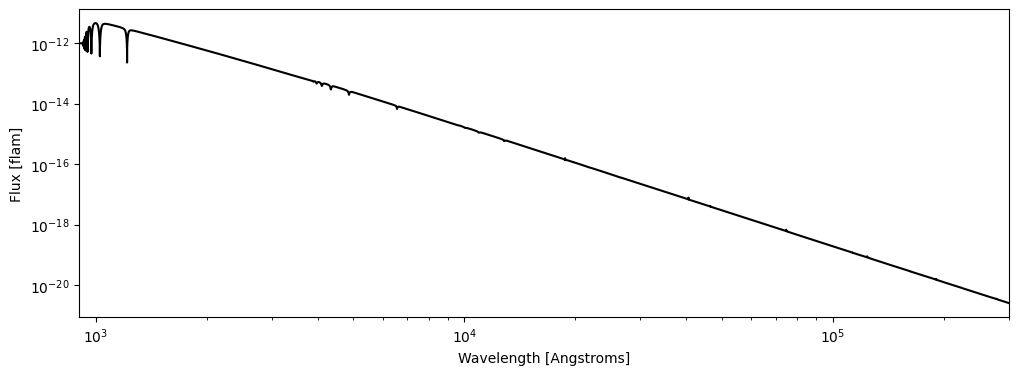

In [4]:
model_wavs, model_flux, _ = ss.load_STIS_spectra("GD153", debug=True)

You can also provide some additional arguments...

- ```filetype```: Either "model" or "stis" to indicate which SED to load
- ```wavelength_bounds```: A list containing the upper and lower wavelength limits

For example...

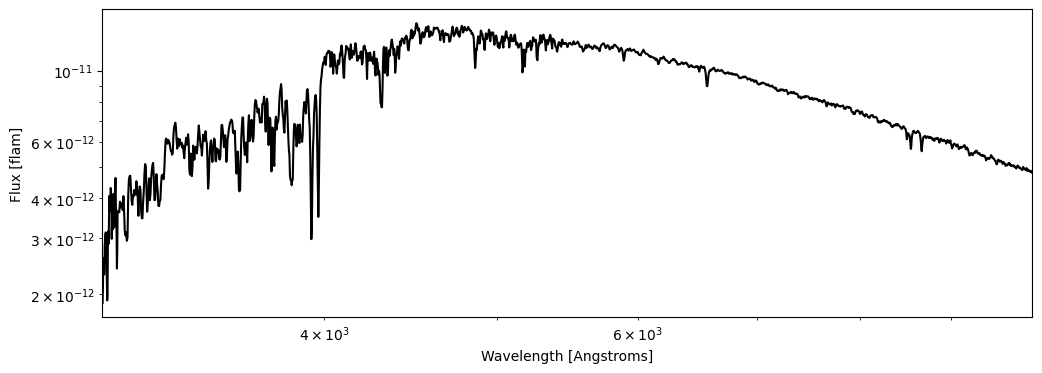

In [43]:
_ = ss.load_STIS_spectra("16 CYG B", 
                         filetype="stis", 
                         wavelength_bounds=[3000, 10000]*u.AA, 
                         debug=True)

**NOTE:** If you use ```"filetype=stis"``` argument, there will be several additional returned arrays / values.

### generate_flux_conversion()

We can use model spectra to determine how CCD counts converts to physical units. Assuming this conversion changes smoothly as a function of wavelength, we can model it using a low-order polynomial. ```generate_flux_conversion()``` tries to do all of this for you! Let's try using it on data for GD153...

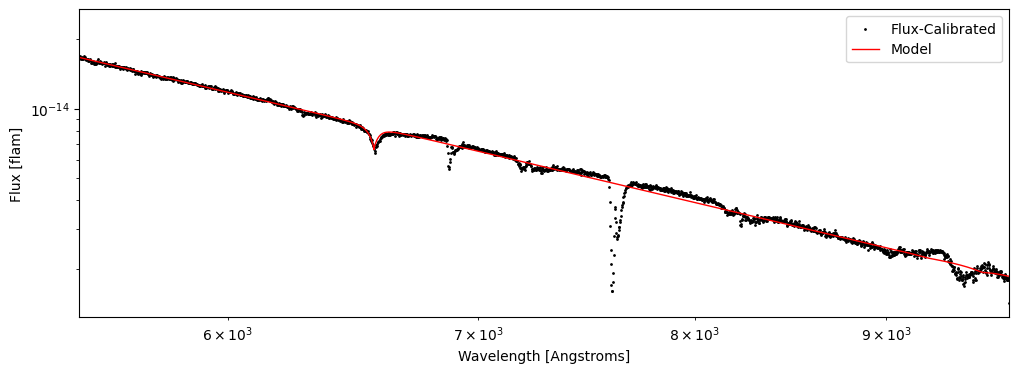

In [47]:
model_wavs, model_flux, _ = ss.load_STIS_spectra("GD153", wavelength_bounds=[5000, 10000]*u.AA)

p_flux = ss.generate_flux_conversion(w_extracted, 
                                     model_wavs, 
                                     flux_extracted, 
                                     model_flux, 
                                     err,
                                     debug=True)

```generate_flux_conversion()``` returns a Numpy polynomial that takes wavelength (in Angstroms) as an argument. This polynomial produces a value with units of physical flux (in flam) over CCD counts. So, to flux-calibrate a SED, we just need to multiply its flux by ```p_flux(wavelengths)```...

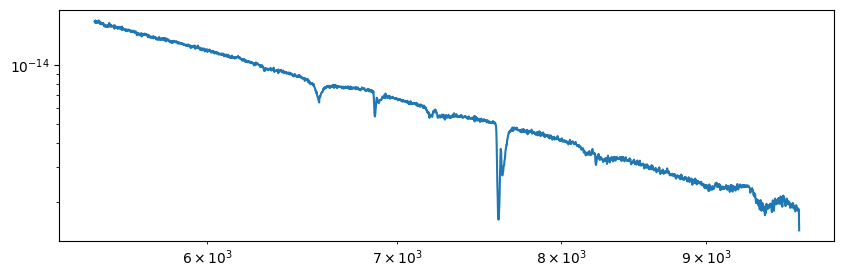

In [36]:
calibrated_gd153 = flux_extracted.flatten()*p_flux(w_extracted)

plt.plot(w_extracted, calibrated_gd153)
plt.xscale("log")
plt.yscale("log")
plt.show()

## __Common Errors__